In [1]:
import numpy as np                      #calculator    
import matplotlib.pyplot as plt         #visualization package              
from scipy.optimize import fsolve       #useful calculator for non-linear equations
from scipy.optimize import curve_fit    #curve fitting if needed
from scipy import interpolate           #interpolation calculator
from numpy.linalg import inv            # For kernel Inversion
from pickle import dump                 # Data Dumper
from pyscenarios.sobol import sobol     # Sample training space
from scipy.optimize import minimize     # Hyper parameter optimization and 

import pandas as pd                     #useful for the import of data from external files
import csv                              #file type used to import data
import gsd                              #file type used by hoomd

import hoomd                            #HOOMD-Blue
import hoomd.md                         #molecular dynamics package
import MDAnalysis                       #wanted to use freud but it wouldn't work through jupyter for some reason
import MDAnalysis.analysis.rdf          #radial distribution function calculator

## Simulation Functions

In [2]:
#Define molecular dynamics simulations
def md_mie(μ, ϵ, σ, β, λ, ν, τ, t): 
    #Equilibration
    hoomd.context.initialize("");
    hoomd.init.create_lattice(unitcell=hoomd.lattice.fcc(a = λ), n = ν);
    nl = hoomd.md.nlist.cell();
    mie = hoomd.md.pair.mie(r_cut=2.5*σ, nlist=nl)
    mie.pair_coeff.set('A', 'A', epsilon = ϵ, sigma= σ, n = μ, m = 6)
    hoomd.md.integrate.mode_standard(dt = τ);
    all = hoomd.group.all();
    hoomd.md.integrate.langevin(group=all, kT= β, seed = 42);
    hoomd.dump.gsd('mie_equil.gsd', period=100, group=all, overwrite=True);
    hoomd.run(5000);
    
    #Molecular dynamics w/ Langevin dynamics
    hoomd.context.initialize("");
    hoomd.init.read_gsd('mie_equil.gsd', frame = 49);
    nl = hoomd.md.nlist.cell();
    mie = hoomd.md.pair.mie(r_cut=2.5*σ, nlist=nl)
    mie.pair_coeff.set('A', 'A', epsilon = ϵ, sigma= σ, n = μ, m = 6)
    hoomd.md.integrate.mode_standard(dt = τ);
    all = hoomd.group.all();
    hoomd.md.integrate.langevin(group = all, kT = β, seed = 42);
    hoomd.dump.gsd('mie.gsd', period = 100, group=all, overwrite=True);
    hoomd.run(t);
    return()

# md_mie:
#     This function is used to establish an equilibrated trajectory beyond which thermodynamic data can be collected.
# arguments:
#     μ    = steepness parameter, n, in the (n-6) Mie potential. n = 12 if initial guess is Lennard-Jones
#     σ    = radial distance from the atomic position where the particle changes from repulsive to attractive force.
#     ϵ    = depth of the Lennard-Jones well. Describes how repulsive the particle is.
#     β    = Thermal energy in reduced units, $k_bT$s
#     λ    = fcc lattice constant to initialize simulation box at target density 
#     ν    = Number of unit cells. Total number of atoms is equal to 4ν^3
#     τ    = Reduced unit timestep in molecular dynamics simulation
#     t    = total number of timesteps for the simulation 
# returns:
#     Initial radial distribution function guess and trajectory file for an (n-6) Mie fluid. 

def mdanalysis(trajectory_filename, r_max, r_min, nbins):                      
    trajectory = MDAnalysis.coordinates.GSD.GSDReader(trajectory_filename)
    topology = MDAnalysis.core.topology.Topology(n_atoms=trajectory[0].n_atoms)
    u = MDAnalysis.as_Universe(topology, trajectory_filename)
    rdf = MDAnalysis.analysis.rdf.InterRDF(g1=u.atoms, g2=u.atoms,nbins = nbins,range=(r_min, r_max)).run()
    return(rdf.bins,rdf.rdf)

# mdanalysis:
#     Computes the radial distribution function for the particles in the simulation using MDAnalysis.
# arguments:
#     trajectory_filename = takes a gsd file from hoomd md simulation and computes the rdf
#     r_max/r_min         = defines the limits of where the rdf will be computed
#     nbins               = number of histograms selected in constructing the rdf   
# returns:
#     rdf.bins = the radius values for the rdf
#     rdf.rdf  = g(r) values at respective distances

## Import Experimental Data

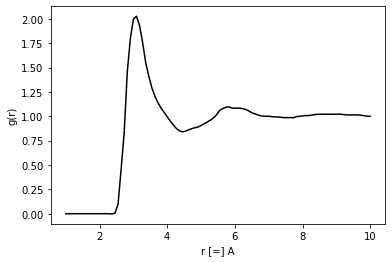

In [3]:
data =  pd.read_csv ('structure-ne.csv') #Read in csv file
neutron = pd.DataFrame (data, columns = ['r','g']) #truncate the csv file to proper size
expRDF = neutron.values #Convert these to values that python can understand
r, rdf = zip(*expRDF) #Unzip the two columns for plotting

bins    = 100
exp_r   = np.linspace(1, 10, bins)
sp_rdf  = interpolate.splrep(r, rdf, s=0)
exp_rdf = interpolate.splev(exp_r, sp_rdf, der=0)

plt.plot(exp_r, exp_rdf, linestyle = '-', color = 'k')
plt.xlabel('r [=] A')
plt.ylabel('g(r)')
plt.show()

## Model Conditions

In [4]:
#Read configuration file, see documentation for format (.csv)
configure = pd.read_csv ('config-ne.csv') 
dat       = pd.DataFrame (configure, columns = ['T','density', 'ref n', 'ref epsilon', 'ref sigma', 'unit cells', 
                                                'timestep', 'runtime', 'convergence']) 
confi     = dat.values 
config_1, config_2, config_3, config_4, config_5, config_6, config_7, config_8, config_9 = zip(*confi)

#Store information from configuration file to python environment
k   = 3.29982916e-27          #boltzmann constant, [kcal/K/particle]   
av  = 6.0223e23               #avagadro number,    [particle/mol]  
T   = config_1[0]             #temperature,        [K]
kbT = k * av * T              #thermal energy,     [kcal/mol]

ρ_s = config_2[0]             #scaled density,     [atom/ang^3]   
lc  = (4/ρ_s)**(1/3)          #fcc lattice constant

ref_n = config_3[0]           #reference steepness parameter, n=12 for Lennard-Jones fluid
ref_ϵ = config_4[0]           #reference potential energy well-depth [kcal/mol]
ref_σ = config_5[0]           #reference sigma [ang]

nu  = int(config_6[0])        #number of unit cells, [total atoms = 4*nu^3]             
atn = 4*nu**3                 #total atoms

timestep   = config_7[0]      #dt for Hamilton equation of motion time integration [picoseconds]
runtime    = config_8[0]      #total number of timesteps for equilibrated simulation

## (n-6) Mie Parameter Priors

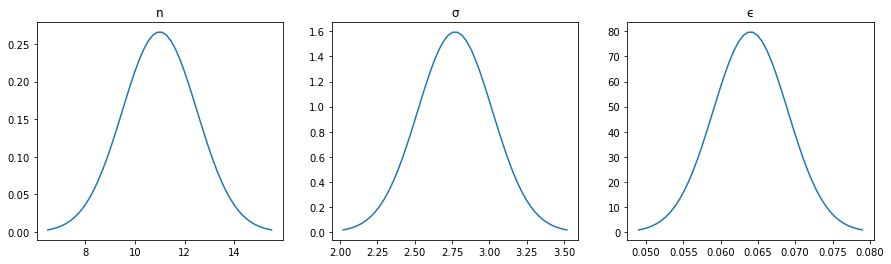

In [5]:
def normal (x, μ, σ):
    return 1/(σ*np.sqrt(2*np.pi))*np.exp((-0.5)*((x - μ)/σ)**2)

#Prior Means and Standard Deviations
n_μ = 11
σ_μ = 2.77
ϵ_μ = 0.064

n_σ = 1.5
σ_σ = 0.25
ϵ_σ = 0.005
σ_n_x   =  np.linspace(0, 1, 100)

#Prior Range
res = 50
n_x = np.linspace(n_μ - 3*n_σ, n_μ + 3*n_σ, res)
σ_x = np.linspace(σ_μ - 3*σ_σ, σ_μ + 3*σ_σ, res)
ϵ_x = np.linspace(ϵ_μ - 3*ϵ_σ, ϵ_μ + 3*ϵ_σ, res)

#Priors
n_prior = normal(n_x, n_μ, n_σ)
σ_prior = normal(σ_x, σ_μ, σ_σ)
ϵ_prior = normal(ϵ_x, ϵ_μ, ϵ_σ)

#Plot Priors

#Plot Priors

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

ax[0].plot(n_x, n_prior, label = 'Integral = ' + str(np.trapz(y = n_prior, x = n_x)))
ax[0].set_title("n")
#ax[0].legend(loc = 'best')
ax[1].plot(σ_x, σ_prior, label = 'Integral = ' + str(np.trapz(y = σ_prior, x = σ_x)))
ax[1].set_title("σ")
#ax[1].legend(loc = 'best')
ax[2].plot(ϵ_x, ϵ_prior, label = 'Integral = ' + str(np.trapz(y = ϵ_prior, x = ϵ_x)))
ax[2].set_title("ϵ")
#ax[2].legend(loc = 'best')
plt.show()

## Molecular Simulations

In [6]:
# First try to import previously run data
try:
    from pickle import load
    input_dict = load(open('model_rdfs.p', 'rb'))
    model_rdf  = input_dict['model_rdf']
    ep_r       = input_dict['ep_r']
    xs         = input_dict['xs']

# If it fails run new simulations
except:
    ndims = 3
    nsims = 100 #number of training simulations for surrogate
    
    model_rdf  = np.empty((nsims, bins)) # 100 x 100 matrix

    # Sobol sampling over the unit box:
    xs = sobol((nsims, ndims))
    # Grid one standard deviation larger than prior range:
    ranges = np.array([[n_μ - 4*n_σ, n_μ + 4*n_σ],
                    [σ_μ - 4*σ_σ, σ_μ + 4*σ_σ],
                    [ϵ_μ - 4*ϵ_σ, ϵ_μ + 4*ϵ_σ]])
    xs = ranges[:, 0] + xs * (ranges[:, 1] - ranges[:, 0])

    for i in range (nsims):
        print("Running Simulation #",i)
        md_mie(μ = xs[i,0], ϵ = xs[i,2], σ = xs[i,1], β = kbT, λ = lc, ν = nu, τ = timestep, t = runtime)
        ep_r, ep_rdf = mdanalysis('mie.gsd', exp_r[-1], exp_r[0], bins)
        model_rdf[i] = ep_rdf
        print()

    from pickle import dump
    output_dict = dict(model_rdf = model_rdf, ep_r = ep_r, xs = xs)
    dump(output_dict, open('model_rdfs.p', 'wb'))

## Sample and Prior Space

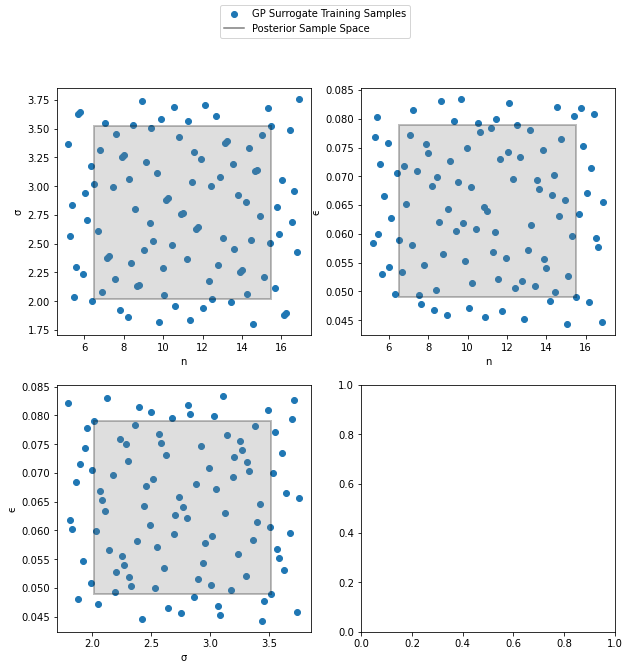

In [7]:
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 10))

ax[0][0].scatter(xs[:, 0], xs[:, 1],label="GP Surrogate Training Samples")
ax[0][0].add_patch(Rectangle((n_μ - 3*n_σ, σ_μ - 3*σ_σ), 6*n_σ, 6*σ_σ,
             edgecolor = 'k',
             facecolor = 'tab:grey', alpha = 0.25,
             fill=True,
             lw=2))
ax[0][0].set_xlabel('n')
ax[0][0].set_ylabel('σ')
ax[0][1].scatter(xs[:, 0], xs[:, 2])
ax[0][1].add_patch(Rectangle((n_μ - 3*n_σ, ϵ_μ - 3*ϵ_σ), 6*n_σ, 6*ϵ_σ,
             edgecolor = 'k',
             facecolor = 'tab:grey', alpha = 0.25,
             fill=True,
             lw=2))
ax[0][1].set_xlabel('n')
ax[0][1].set_ylabel('ϵ')
ax[1][0].scatter(xs[:, 1], xs[:, 2])
ax[1][0].add_patch(Rectangle((σ_μ - 3*σ_σ, ϵ_μ - 3*ϵ_σ), 6*σ_σ, 6*ϵ_σ,
             edgecolor = 'k',
             facecolor = 'tab:grey', alpha = 0.25,
             fill=True,
             lw=2))
ax[1][0].set_xlabel('σ')
ax[1][0].set_ylabel('ϵ')
ax[1][0].plot([2],[0.05], color='tab:grey',label="Posterior Sample Space")
fig.legend(loc='upper center')
plt.show()

## Surrogate Model Approximation

In [8]:
# Returns the distance matrix between two arrays. 
def radius(x, y, l):
    dist = np.zeros((len(x), len(y)))
    for i in range (len(x)):
        for j in range (len(y)):
            dist[i][j] = np.sum(((x[i] - y[j])/l)**2)
    return dist

# Squared Exponential Kernel
def kernel(R, width):
    return width**2 * np.exp(-(R))

# Hyper Parameter Optimization

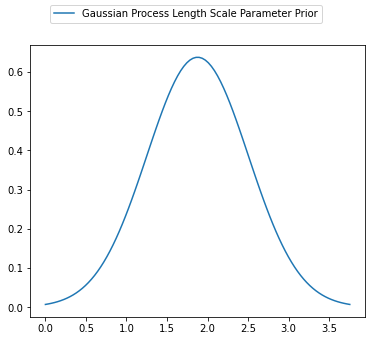

In [9]:
# N Lengthscale Prior 
low0 = min((radius(np.transpose(xs)[0],np.transpose(xs)[0],[1]) + 9999999*np.diag(np.ones(len(np.transpose(xs)[0])))).flatten())
l_μ0 = (max(np.transpose(xs)[0]) -  low0)/2 + low0
l_σ0 = (max(np.transpose(xs)[0]) -  low0)/6

# σ Lengthscale Prior 
low1 = min((radius(np.transpose(xs)[1],np.transpose(xs)[1],[1]) + 9999999*np.diag(np.ones(len(np.transpose(xs)[1])))).flatten())
l_μ1 = (max(np.transpose(xs)[1]) - low1)/2 + low1
l_σ1 = (max(np.transpose(xs)[1]) -  low1)/6

# ϵ Lengthscale Prior 
low2 = min((radius(np.transpose(xs)[2],np.transpose(xs)[2],[1]) + 9999999*np.diag(np.ones(len(np.transpose(xs)[2])))).flatten())
l_μ2 = (max(np.transpose(xs)[2]) - low2)/2 + low2
l_σ2 = (max(np.transpose(xs)[2]) -  low2)/6

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (6, 5))
ax.plot(np.linspace(low1,max(np.transpose(xs)[1]),100),(normal(np.linspace(low1,max(np.transpose(xs)[1]),100),l_μ1,l_σ1)),label="Gaussian Process Length Scale Parameter Prior")
fig.legend(loc = "upper center")
plt.show()

In [10]:
# Log marginal LH of a given set of hyper parameters. As seen inside Rasmussen and Williams.
def log_marginal_LH_Sub(arr):
    global y
    σn = arr[0]
    l = arr[1:4]
    w = arr[4]
    k = kernel(radius(xs,xs,l),w) + np.diag(σn*np.ones(len(xs)))
    kinv = inv(k)
    sign, logdet = np.linalg.slogdet(k)
    out = -1*(-(0.5)*(y.transpose() @ kinv @ y)- logdet - (len(y)/2)*np.log(2*np.pi) 
            + np.log(normal(l[0],l_μ0,l_σ0)) + np.log(normal(l[1],l_μ1,l_σ1)) + np.log(normal(l[2],l_μ2,l_σ2)))
    return out

In [11]:
# Try to load previously calcualted hyper parameters 
try:
    input_dict = load(open('hyperP.p', 'rb'))
    hyper_params = input_dict['hyper_params']
    
# If fails then run hyper parameters calculation by optimizing the log marginal LH.
except:
    bnds_n = ((1e-4, None),(1e-4, None),(1e-4, None),(1e-4, None),(1e-4, None))
    hyper_params = []
    for index in range(len(ep_r)): 
        if index % 10 == 0:
            print("Index: " + str(index))
        y = model_rdf.transpose()[index]
        out = minimize(log_marginal_LH_Sub, (1.00000000e-04, 8.00899884e+00, 6.70857894e+00, 5.37515432e-01,
       9.69465617e+00), method='L-BFGS-B', bounds=bnds_n, options={'disp': True})
        hyper_params.append(out['x'])
    output_dict = dict(hyper_params = hyper_params)
    dump(output_dict, open('hyperP.p', 'wb'))

In [12]:
# Average the most optimal hyper parameter for each GP in the subset of GPS
ℓ   = np.array([np.sum(np.transpose(hyper_params)[1])/100,np.sum(np.transpose(hyper_params)[2])/100, np.sum(np.transpose(hyper_params)[3])/100])
w   = np.sum(np.transpose(hyper_params)[4])/100
σ_diag = np.sum(np.transpose(hyper_params)[0])/100

Rdd    = radius(xs, xs, ℓ)
Kdd    = kernel(Rdd, w) + np.diag(σ_diag**2*np.ones(len(Rdd)))
KddInv = inv(Kdd)

# Define the surrogate model, A subset of gaussian processes. 
def surrogate(n, σ, ϵ):
    xi  = np.array([[n, σ, ϵ]])
    Rii = radius(xi, xi, ℓ)
    Rid = radius(xi, xs, ℓ)
    Kii = kernel(Rii, w)
    Kid = kernel(Rid, w)
    
    μi    = np.zeros(100)
    y_arr = np.array([model_rdf]).transpose()
    for i in range (100):
        y     = y_arr[i]
        μi[i] = ((Kid @ KddInv) @ (y))
        
    return μi

## Inverse Problem

In [13]:
# Exponential of the nuisance param
def prior_exp(x, mu, sigma):
    return (-0.5)*((x - mu)/(sigma))**2

# The prior for the nuisance parameter/sigma term in the gaussian LH 
def prior_σn(x, mu, sigma):
    return (1/(x*sigma*np.sqrt(2*np.pi)))*np.exp(-(np.log(x) - mu)**2/(2*sigma**2))

# Sum of squared error between experimental data and GP prediction
def ssqFunc(arr):
    n     = arr[0]
    sigma = arr[1]
    epsil = arr[2]
    
    surrogate_rdf = surrogate(n, sigma, epsil)
    ssq = np.sum((surrogate_rdf - exp_rdf)**2)
    
    return ssq

# Returns the a value proptoposterior probability of a given set of n,sigma,epsilon, and the 
# nuisance parameter/sigma term in the gaussian LH 
def posterior (ssq,arr):
    
    n     = arr[0]
    sigma = arr[1]
    epsil = arr[2]
    nuisa = arr[3]
    
    return 1/(nuisa*(bins/2))*prior_σn(nuisa, 0.05, 3)*np.exp(-ssq/(2*nuisa**2) + prior_exp(n, n_μ, n_σ) + prior_exp(sigma, σ_μ, σ_σ) + prior_exp(epsil, ϵ_μ, ϵ_σ))


In [14]:
# First try to load in calcuated posterior
try:
    input_dict = load(open('joint.p', 'rb'))
    joint = input_dict['joint']
    σ_n   =  np.linspace(0.01, 4, 50)

# If it doesnt exist, calculate the posterior over a grid of inputs so we can view it
except:
    σ_n   =  np.linspace(0.01, 4, 50)
    joint = np.zeros((len(n_x), len(σ_x), len(ϵ_x), len(σ_n)))
    ssq_p = 0
    for i in range (len(n_x)):
        print("i:",i)
        for j in range (len(σ_x)):
            for k in range (len(ϵ_x)):
                ssq_p = ssqFunc([n_x[i], σ_x[j], ϵ_x[k]])
                for m in range (len(σ_n)):
                    joint[i, j, k, m] = posterior(ssq_p, [n_x[i], σ_x[j], ϵ_x[k], σ_n[m]])
                
    output_dict = dict(joint = joint)
    dump(output_dict, open('joint.p', 'wb'))

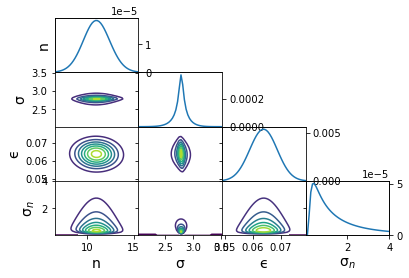

In [15]:
from scatterplotmatrix import contour_matrix

contour_matrix(joint, [n_x, σ_x, ϵ_x, σ_n], 
              ['n', 'σ', 'ϵ', 'σ$_n$'])
plt.show()

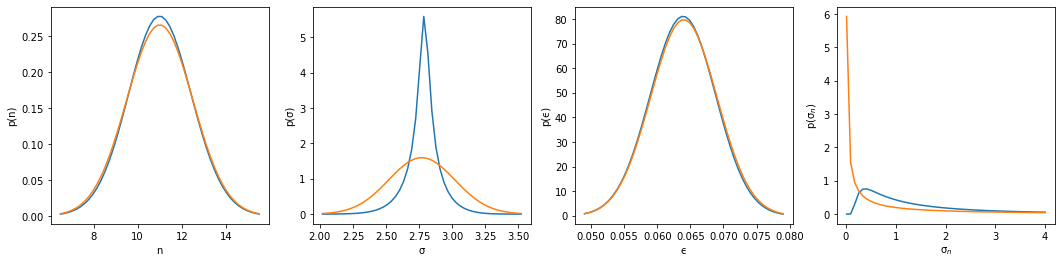

In [16]:
n_marg = np.trapz(y = np.trapz(y = np.trapz(y = joint, axis = 2, x = ϵ_x), axis = 1, x = σ_x), axis = 1, x = σ_n)
n_marg/= np.trapz(y = n_marg, x = n_x)

σ_marg = np.trapz(y = np.trapz(y = np.trapz(y = joint, axis = 0, x = n_x), axis = 1, x = ϵ_x), axis = 1, x = σ_n)
σ_marg/= np.trapz(y = σ_marg, x = σ_x)

ϵ_marg = np.trapz(y = np.trapz(y = np.trapz(y = joint, axis = 0, x = n_x), axis = 0, x = σ_x), axis = 1, x = σ_n)
ϵ_marg/= np.trapz(y = ϵ_marg, x = ϵ_x)

σn_marg = np.trapz(y = np.trapz(y = np.trapz(y = joint, axis = 0, x = n_x), axis = 0, x = σ_x), axis = 0, x = ϵ_x)
σn_marg/= np.trapz(y = σn_marg, x = σ_n)
σn_prior = prior_σn(σ_n, 0.05, 3)
σn_prior/= np.trapz(y = σn_prior, x = σ_n)

fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize = (18, 4))

ax[0].plot(n_x, n_marg)
ax[0].plot(n_x, n_prior)
ax[0].set_xlabel('n')
ax[0].set_ylabel('p(n)')
ax[1].plot(σ_x, σ_marg)
ax[1].plot(σ_x, σ_prior)
ax[1].set_xlabel('σ')
ax[1].set_ylabel('p(σ)')
ax[2].plot(ϵ_x, ϵ_marg)
ax[2].plot(ϵ_x, ϵ_prior)
ax[2].set_xlabel('ϵ')
ax[2].set_ylabel('p(ϵ)')
ax[3].plot(σ_n, σn_marg)
ax[3].plot(σ_n, σn_prior)
ax[3].set_xlabel('σ$_n$')
ax[3].set_ylabel('p(σ$_n$)')
plt.show()

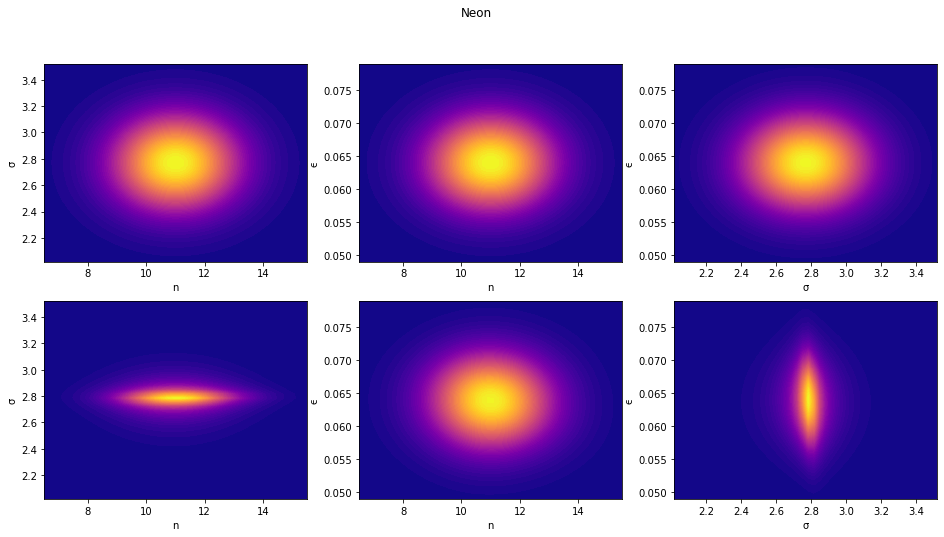

In [17]:
nσ_marg = np.trapz(y = np.trapz(y = joint, axis = 3, x = σ_n), axis = 2, x = ϵ_x)
nϵ_marg = np.trapz(y = np.trapz(y = joint, axis = 3, x = σ_n), axis = 1, x = σ_x)
σϵ_marg = np.trapz(y = np.trapz(y = joint, axis = 3, x = σ_n), axis = 0, x = n_x)

nσ_prior_joint = np.zeros((50,50))
for i in range(len(n_x)):
    for j in range(len(σ_x)):
        nσ_prior_joint[i][j] = n_prior[i]*σ_prior[j]
        
nϵ_prior_joint = np.zeros((50,50))
for i in range(len(n_x)):
    for j in range(len(ϵ_x)):
        nϵ_prior_joint[i][j] = n_prior[i]*ϵ_prior[j]
        
σϵ_prior_joint = np.zeros((50,50))
for i in range(len(σ_x)):
    for j in range(len(ϵ_x)):
        σϵ_prior_joint[i][j] = σ_prior[i]*ϵ_prior[j]
        
show_prior = True
if show_prior == True:
    fig, ax = plt.subplots(2,3,figsize = (16, 8))
    ax[0, 0].contourf(n_x, σ_x, nσ_prior_joint.T, 69, cmap = 'plasma')
    ax[0, 0].set_xlabel("n")
    ax[0, 0].set_ylabel("σ")
    
    ax[1, 0].contourf(n_x, σ_x, nσ_marg.T, 69, cmap = 'plasma')
    ax[1, 0].set_xlabel("n")
    ax[1, 0].set_ylabel("σ")
    
    ax[0, 1].contourf(n_x, ϵ_x, nϵ_prior_joint.T, 69, cmap = 'plasma')
    ax[0, 1].set_xlabel("n")
    ax[0, 1].set_ylabel("ϵ")
    
    ax[1, 1].contourf(n_x, ϵ_x, nϵ_marg.T, 69, cmap = 'plasma')
    ax[1, 1].set_xlabel("n")
    ax[1, 1].set_ylabel("ϵ")
    
    ax[0, 2].contourf(σ_x, ϵ_x, σϵ_prior_joint.T, 69, cmap = 'plasma')
    ax[0, 2].set_xlabel("σ")
    ax[0, 2].set_ylabel("ϵ")
    
    ax[1, 2].contourf(σ_x, ϵ_x, σϵ_marg.T, 69, cmap = 'plasma')
    ax[1, 2].set_xlabel("σ")
    ax[1, 2].set_ylabel("ϵ")
    fig.suptitle("Neon")
    plt.savefig("NePOST")
else:
    fig, ax = plt.subplots(1,3,figsize = (12, 4))
    ax[0].contourf(n_x, σ_x, nσ_marg.T, 69, cmap = 'plasma')
    ax[1].contourf(n_x, ϵ_x, nϵ_marg.T, 69, cmap = 'plasma')
    ax[2].contourf(σ_x, ϵ_x, σϵ_marg.T, 69, cmap = 'plasma')
    plt.show()

## Comparing Experimental Data to MAP Estimate

In [18]:
from scipy.optimize import minimize

def logposterior (arr):
    
    n     = arr[0]
    sigma = arr[1]
    epsil = arr[2]
    ssq = ssqFunc([n, sigma, epsil])
    nuisa = arr[3]
    
    return -np.log(1/(nuisa*(bins/2))*prior_σn(nuisa, 0.05, 3)*np.exp(-ssq/(2*nuisa**2) + prior_exp(n, n_μ, n_σ) + prior_exp(sigma, σ_μ, σ_σ) + prior_exp(epsil, ϵ_μ, ϵ_σ)))

mindict = minimize(logposterior, np.array([11, 2.77, 0.063, 0.5]), method = 'Nelder-Mead')
mode = mindict['x']
print(mode)

md_mie(μ = mode[0], ϵ = mode[2], σ = mode[1], β = kbT, λ = lc, ν = nu, τ = timestep, t = runtime)
ep_r, ep_rdf = mdanalysis('mie.gsd', exp_r[-1], exp_r[0], bins)




[11.08342149  2.78750046  0.06399236  0.23209159]
HOOMD-blue 2.9.2 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 06/26/2020
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 500 particles
notice(2): integrate.langevin/bd is using specified gamma values
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 500
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:06 | Step 5000 / 5000 | TPS 771.213 | ETA 00:00:00
Average TPS: 771.111
---------
-- Neighborlist stats:
104 normal updates / 

/Users/evanzambudio/opt/anaconda3/envs/hoomd/lib/python3.8/site-packages/MDAnalysis/coordinates/base.py:865: UserWarning: Reader has no dt information, set to 1.0 ps
  warnings.warn("Reader has no dt information, set to 1.0 ps")


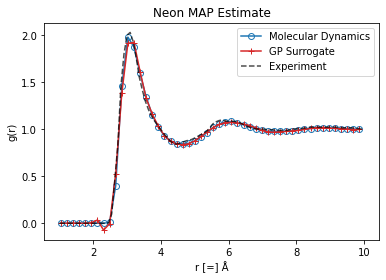

In [19]:
plt.plot(ep_r[::2], ep_rdf[::2], color = 'tab:blue', 
         marker = 'o', markerfacecolor = 'none', linestyle = '-', label = 'Molecular Dynamics')
plt.plot(ep_r[::2], surrogate(mode[0], mode[1], mode[2])[::2], color = 'tab:red'
         , marker = '+', markerfacecolor = 'none', linestyle = '-', label = 'GP Surrogate')
plt.plot(exp_r, exp_rdf, color = 'k', alpha = 0.7, linestyle = '--', label = 'Experiment')
plt.legend()
plt.xlabel('r [=] Å')
plt.ylabel('g(r)')
plt.savefig('rdfs', dpi=600, facecolor='w', edgecolor='w',
        orientation='portrait', format=None,
        transparent=False, bbox_inches=None, pad_inches=0.01, metadata=None)
plt.title("Neon MAP Estimate")
plt.savefig("NeMAP")